# This is the StarDist Demo Notebook
## For the Crick 3D Segmenation Course, September 2024
### Todd Fallesen CALM

# Do the imports of packages


In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 200
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
#from stardist.models import Config3D, StarDist3D, StarDistData3D
from skimage import filters
from skimage.segmentation import clear_border
from skimage.transform import rescale, resize, downscale_local_mean

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
lbl_cmap = random_label_cmap()

import os

C:\Users\fallest\AppData\Local\Temp\ipykernel_37940\180650227.py:5: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  matplotlib.rcParams["image.interpolation"] = None


In [2]:
from stardist.models import Config3D, StarDist3D, StarDistData3D

# Import data
We can either import a single image, or import a group of images
We then normalize the images

In [3]:
image_path = "C:\\3D_Segmentation\\3d_monolayer_xy1_ch2.tif"
#image_path = "C:\\3D_Segmentation\\*.tif" #path where images are
save_path = "C:\\3D_Segmentation\\output\\StarDist\\"  #make sure there are slashes at the end

In [5]:
X = sorted(glob(image_path))
X = X
file_list = []
for name in X:
    file_list.append(os.path.basename(name))

In [6]:
#Check the files were listed correctly
X

['C:\\3D_Segmentation\\3d_monolayer_xy1_ch2.tif']

In [7]:
#read in the images, normalize the images

X = [image_path] # put this in a list, so if we want to change this to iterate through multiple images later, it's easier
X = list(map(imread,X))
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [8]:
np.shape(X)

(1, 60, 256, 256)

## Show a test image

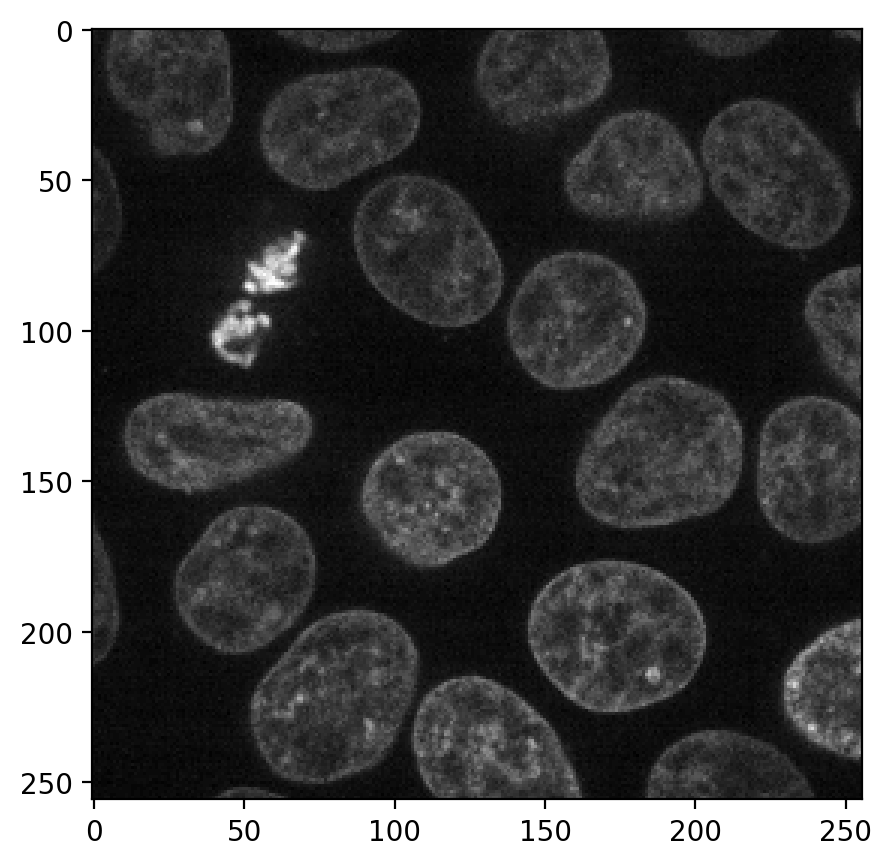

In [9]:
# show all test images
if True:
    plt.figure(figsize=(8,5))
    plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')
None;

# Do any image pre-processing

(60, 128, 128)

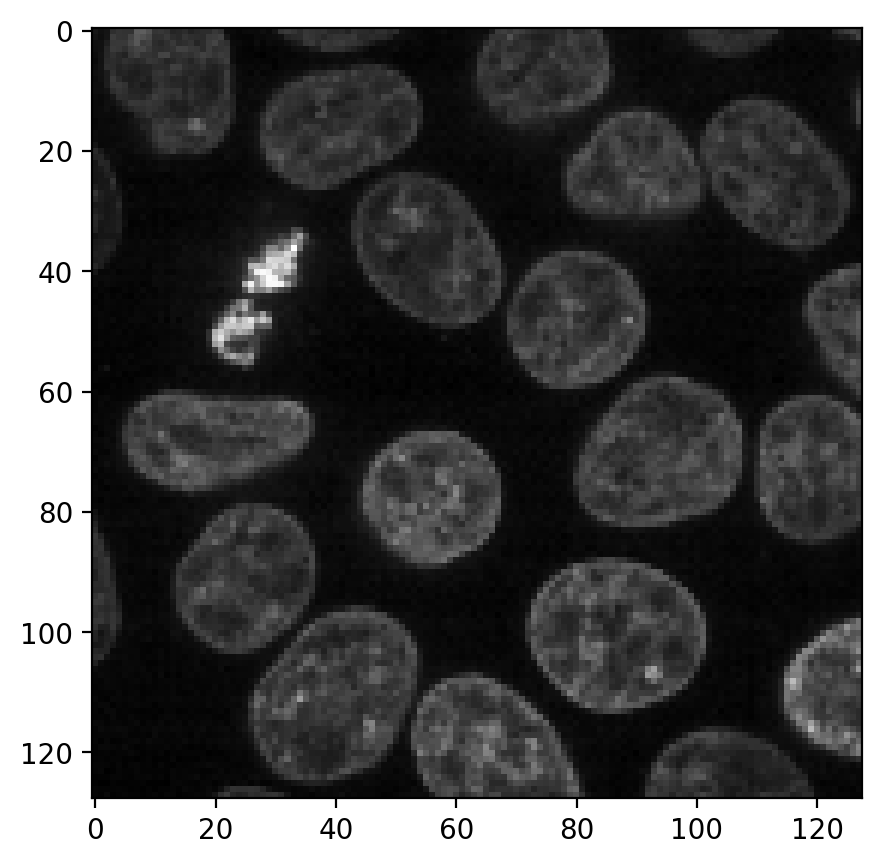

In [16]:
Do_Rescale = True
Do_Gauss = False
Do_Median = False

sigma = 1
rescale_factor = 0.5

if Do_Rescale:
    for i in range(0,len(X)):
        X[i] = rescale(X[i], (1,rescale_factor, rescale_factor), anti_aliasing=False)

if Do_Gauss:
    for i in range(0,len(X)):
        X[i] = filters.gaussian(X[i], sigma=sigma)
        
if Do_Median:
    for i in range(0,len(X)):
        X[i] = filters.median(X[i], sigma=sigma)
        

# show all test images

plt.figure(figsize=(8,5))
plt.imshow(X[0][X[0].shape[0]//2],cmap='gray')

X[0].shape

## Set up the StarDist pretrained model

In [17]:
model_name = '3D_demo'
model = StarDist3D.from_pretrained(model_name)

Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


In [18]:
Automatic_number_of_tiles = True

n_tiles_Z =  4
n_tiles_Y =  12
n_tiles_X =  12

if (Automatic_number_of_tiles):
    n_tilesZYX = None
    n_tilesZYX = model._guess_n_tiles(X[0]) #guesses on the first image


if not (Automatic_number_of_tiles):
    n_tilesZYX = (n_tiles_Z, n_tiles_Y, n_tiles_X)

# Run stardist



In [19]:
run_demo = True #this can be True or False # 
run_series = True #this can be True or False

In [20]:
#took 486s for 100mb on laptop.  #This only predicts on the first image in your dataset, and doesn't save it
if run_demo:
    for image in X:
        img = normalize(X[0], 1,99.8, axis=axis_norm) # predict on the first image in the list
        labels, details = model.predict_instances(img)
else:
    print("Run Demo wasn't set to true. Run demo didn't run")

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


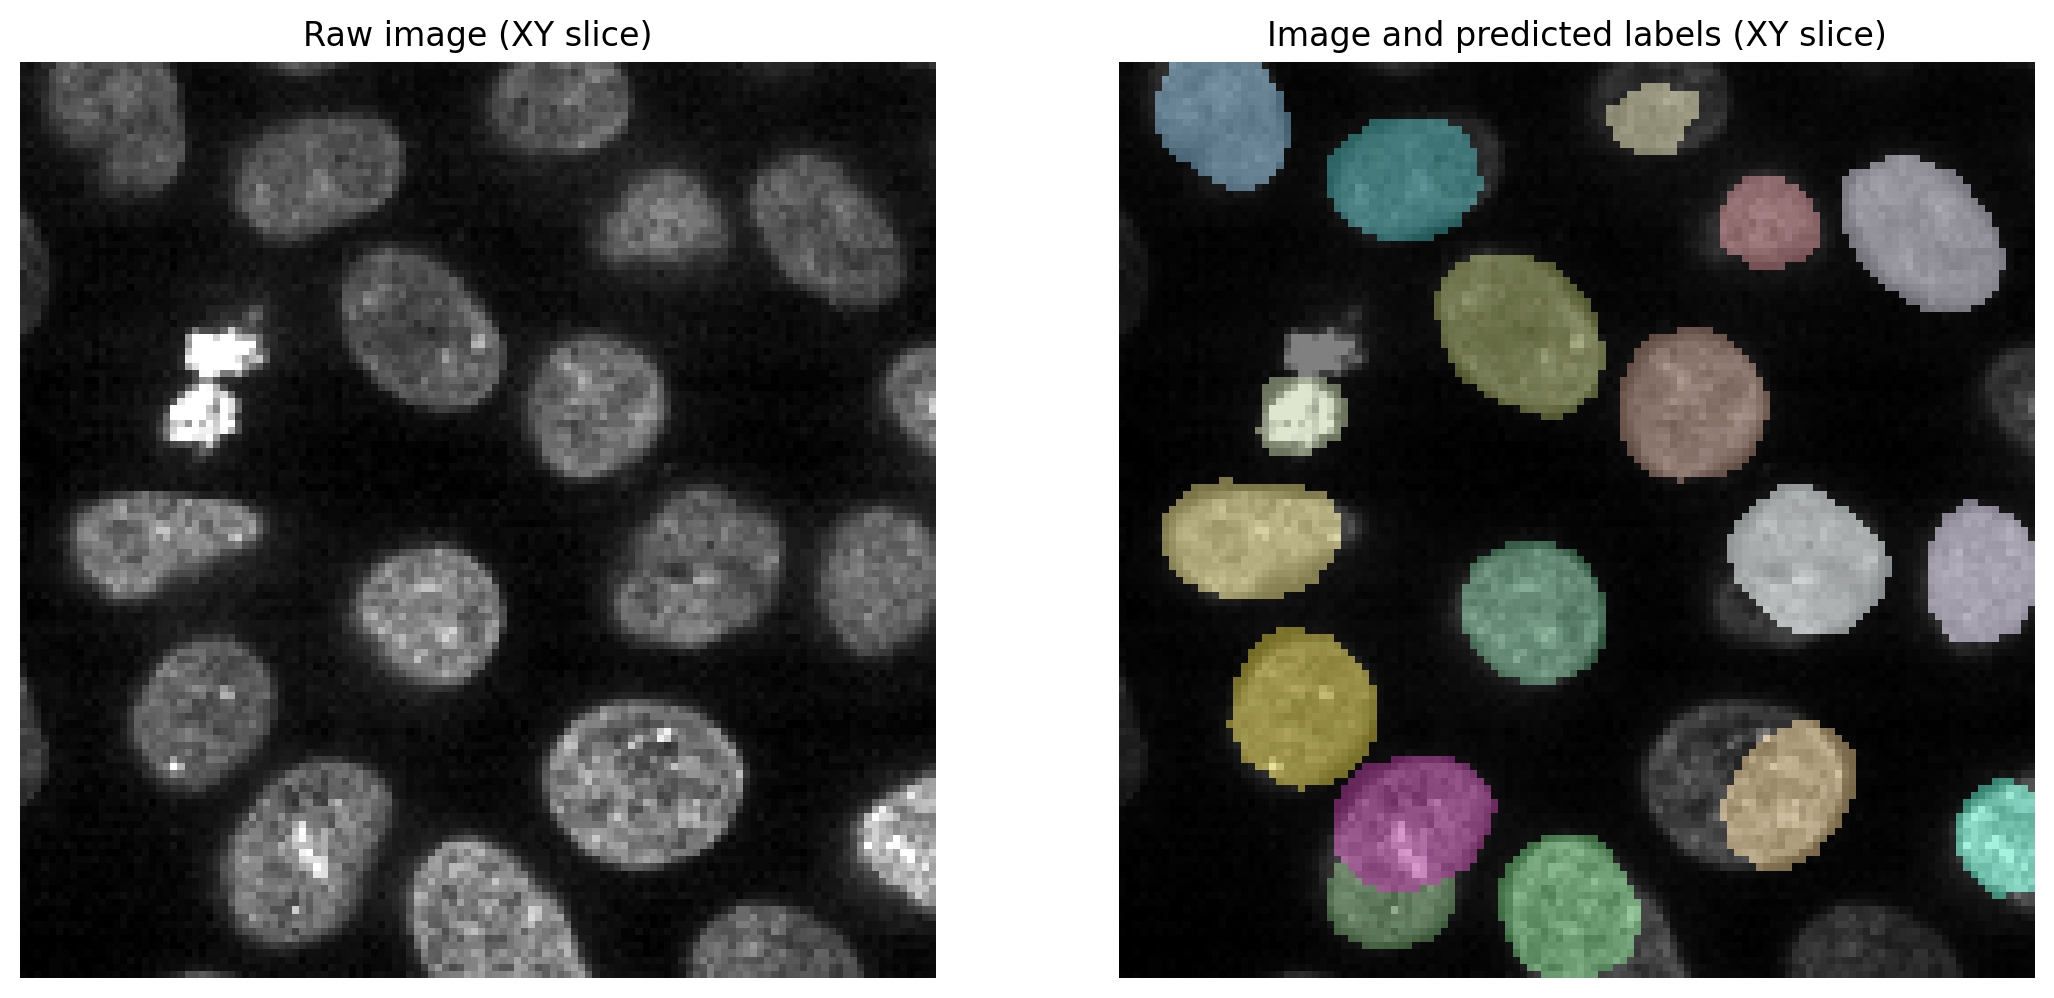

In [21]:
if run_demo:
    plt.figure(figsize=(13,10))
    z = max(0, img.shape[0] // 2 - 5)
    plt.subplot(121)
    plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
    plt.title('Raw image (XY slice)')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow((img if img.ndim==3 else img[...,:3])[z], clim=(0,1), cmap='gray')
    plt.imshow(labels[z], cmap=lbl_cmap, alpha=0.5)
    plt.title('Image and predicted labels (XY slice)')
    plt.axis('off');

else:
    print("Run Demo wasn't set to true. Run demo didn't run")

In [22]:
if run_series:
    print("Working on model: ", model_name, " now")
    save_directory = os.path.join(save_path, model_name)
    Path(save_directory).mkdir(parents=True, exist_ok=True)

    for i in range(0,len(X)):
        img = normalize(X[i], 1,99.8, axis=axis_norm)
        labels, polygons = model.predict_instances(img, n_tiles=n_tilesZYX)
        print("There are :", np.max(labels), " labels in ", file_list[i])
        save_tiff_imagej_compatible(save_directory+file_list[i][:-4]+'_labels.tif', labels, axes='ZYX')
        #the 16 bit doen't work if more than 65k cells. 
        
else:
    print("Run series wasn't set to true. Your series won't run")

Working on model:  3D_demo  now
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 25%|█████████████████████                                                               | 1/4 [00:01<00:05,  1.75s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 50%|██████████████████████████████████████████                                          | 2/4 [00:03<00:03,  1.86s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:05<00:01,  1.98s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.00s/it]


There are : 37  labels in  3d_monolayer_xy1_ch2.tif


__init__.py (43): Converting data type from 'int32' to ImageJ-compatible 'int16'.
